In [1]:
import sys
print(sys.executable)
print(sys.version)
print(sys.version_info)

import math
import astropy
print('astropy',astropy.__version__ )
from spectral_cube import SpectralCube      # This is a handy package for working with 3D data cubes
from spectral_cube import LazyMask
from astropy.coordinates import SkyCoord
from reproject import reproject_interp      
from reproject.mosaicking import find_optimal_celestial_wcs 
import regions
import reproject
print('reproject',reproject.__version__)
import spectral_cube
print('spectral_cube',spectral_cube.__version__)
import numpy as np                          
import pylab                                
import matplotlib 
import matplotlib.gridspec as gridspec                                                                                             
import scipy
import astropy.io.fits as fits                                                          
from astropy.wcs import WCS                 
from astropy import units as u              
import pyspeckit as psk   
import astrodendro
import matplotlib.colors as colors
from matplotlib import pyplot as plt
# Suppress warnings we don't care about:
import sys
import gc
from astropy.convolution import Gaussian1DKernel
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
%matplotlib inline
from astrodendro.analysis import PPVStatistic


print(astrodendro.__file__)

from matplotlib.patches import Ellipse
import copy
from tqdm import tqdm
import radio_beam
from astropy.table import Table

from scipy.optimize import curve_fit
from scipy.optimize import leastsq
#%matplotlib widget

#Create a function that uses the dendrogram input to calculate all the quantities, and has the size and linewidth requirements of the Shetty paper
#Requires the computed dendrogram, the data from the line image, the velocity axis, and the data from the Continuum image, as well as metadata for the structures
#Finds Size, Linewidth, Luminosity, and Column Density of a structure for each structure and returns them in [[][]] arrays [Leaves][Branches]
#Continuum is in Jansky/Beam, Line data should have the unit specified in the metadata as 'data_unit'

def Dendro_Arrays(Dendrogram,LineData,DataVel,ContData,metadata,ColD = True):
    SizeA,SigmaA,LuminA,CDA,SIDS,MOM0_FLUX,Distances = [[],[],[],[]],[[],[],[],[]],[[],[]],[[],[]],[[],[]],[[],[]],[[],[]]
    print(metadata)
    #catalog = astrodendro.ppv_catalog(d, metadata)
    center = SkyCoord('00h47m33.14s' ,'-25d17m17.52s',frame='icrs')
    center_ra_pix,center_dec_pix = int(metadata['wcsu'][:][:][0].world_to_pixel(center)[0]),int(metadata['wcsu'][:][:][0].world_to_pixel(center)[1])
    sliced= LineData[12]
    CubeShape = np.shape(sliced)
    for t in Dendrogram.all_structures: 

        I = t.indices()
        Cont = True
        if t.is_branch:
                if t.parent==None:
                    Cont=True
                else:
                    Cont = True
        
        for lmi in range(len(I[0])):
            NansNE=0
            NansSE=0
            NansNW=0
            NansSW=0
            Length = 10
            #I[1][lmi+10]>
            for lmj in range(Length):
                #Check four 45 degree prongs from each point and see if they have at least 7 nans in 10 pixels. If that happens its too close to the boundary
                if(sliced[I[1][lmi]+lmj,I[2][lmi]-lmj]>0 or sliced[I[1][lmi]+lmj,I[2][lmi]-lmj]<0 ):
                    pass
                else:
                    NansSE+=1
                if(sliced[I[1][lmi]-lmj,I[2][lmi]-lmj]>0 or sliced[I[1][lmi]-lmj,I[2][lmi]-lmj]<0 ):
                    pass
                else:
                    NansSW+=1
                if(sliced[I[1][lmi]-lmj,I[2][lmi]+lmj]>0 or sliced[I[1][lmi]-lmj,I[2][lmi]+lmj]<0 ):
                    pass
                else:
                    NansNW+=1
                if(sliced[I[1][lmi]+lmj,I[2][lmi]+lmj]>0 or sliced[I[1][lmi]+lmj,I[2][lmi]+lmj]<0 ):
                    pass
                else:
                    NansNE+=1
            if(NansNE>Length-3 or NansNW>Length-3 or NansSE>Length-3 or NansSW>Length-3):
                Cont=False
                break

        if(Cont):
            s = PPVStatistic(t,metadata=metadata)
            if((float((s.radius*np.pi/180*3.5/u.deg)))*10**6<18 and (float((s.radius*np.pi/180*3.5/u.deg)))*10**6>4.3/5 and (float(s.v_rms/u.km*u.s))>.01):
            #if( (float((s.radius*np.pi/180*3.5/u.deg)))*10**6>4.3/5 and (float(s.v_rms/u.km*u.s))>.01):
            #if((float((s.radius*np.pi/180*3.5/u.deg)))*10**6<18 and (float((s.radius*np.pi/180*3.5/u.deg)))*10**6>.5 and (float(s.v_rms/u.km*u.s))>.2):

                nproj_pix=len(set(zip(*tuple(I[i] for i in [1,2]))))
                v_IWM = np.nansum(LineData[I]*(DataVel[I[0]])/u.km*u.s)/np.nansum(LineData[I])
                sig_Sh = np.sqrt(np.nansum(LineData[I]*((DataVel[I[0]])/u.km*u.s-v_IWM)**2)/np.nansum(LineData[I])) 
                
                #The flux from the continuum
                #Convert to Jansky from Jansky per beam:
                if(ColD ==True):
                    Cont_Flux=0

                    proj = tuple(set(zip(*tuple(I[i] for i in [1,2]))))
                    for lmi in range(len(proj)):

                        Cont_Flux+=ContData[proj[lmi]]
                    Cont_Flux=Cont_Flux/(metadata['beam_area_ratioc']*(2*np.sqrt(2*np.log(2))))*u.pix**2*u.beam/u.beam*u.Jy#SHould be input as Jansky /beam and will be converted to Jansky, then to unitless. The beam is changed from FWHM to Gaussian
                    Dust_Column = Flux_to_Mass(Cont_Flux)*Num_per_kg/((s.radius*np.pi/180*3.5/u.deg)**2*(3.086*10**24)**2)/np.pi*(1.989*10**30*u.kg/u.M_sun)/u.kg
                else:
                    Dust_Column=0
                if(str(Dust_Column) == str(np.nan) or str(Dust_Column)==str(np.inf)):
                    Dust_Column=0
                lum = Flux_to_Lum(s.flux)
                s_flux = s.flux

                Index = tuple(I[i] for i in [0,1,2])
                K_Km_s_Flux=np.nansum(LineData[Index]*metadata["velocity_scale"])#Find the total flux from the structures in K km/s, assuming the input data is in K as it should be, 
                
                
                #print(catalog[t.idx]['radius']*np.pi/180*3.5/u.deg,s.radius*np.pi/180*3.5/u.deg)
                #print(catalog[t.idx]['v_rms'],(float(s.v_rms/u.km*u.s)))
                
                Distance = np.sqrt((float(s.x_cen/u.pix)-center_ra_pix)**2+(float(s.y_cen/u.pix)- center_dec_pix)**2)*metadata['spatial_scale']*np.pi/180*3.5*10**6/u.deg#pc dist from barycenter
                if(t.is_leaf):

                    SizeA[0].append((float((s.radius*np.pi/180*3.5/u.deg)))) #define size as astrodendro
                    SigmaA[0].append((float(s.v_rms/u.km*u.s)))#
                    CDA[0].append(float(Dust_Column))
                    LuminA[0].append(float(lum*u.Hz*u.s/u.erg))
                    SIDS[0].append(float(t.idx))
                    MOM0_FLUX[0].append(float(K_Km_s_Flux*u.s/u.km))
                    Distances[0].append(float(Distance))
                if(t.is_branch	):

                    SizeA[1].append((float((s.radius*np.pi/180*3.5/u.deg)))) #define size as astrodendro
                    SigmaA[1].append((float(s.v_rms/u.km*u.s)))#
                    CDA[1].append(float(Dust_Column))
                    LuminA[1].append(float(lum*u.Hz*u.s/u.erg))
                    SIDS[1].append(float(t.idx))
                    MOM0_FLUX[1].append(float(K_Km_s_Flux*u.s/u.km))
                    Distances[1].append(float(Distance))
                    
                    
                    
    SizeA[0] = np.array(SizeA[0],dtype=type(1.))
    SizeA[1] = np.array(SizeA[1],dtype=type(1.))
    SizeA[2] = np.array(SizeA[2],dtype=type(1.))
    SizeA[3] = np.array(SizeA[3],dtype=type(1.))
    SigmaA[0] = np.array(SigmaA[0],dtype=type(1.))
    SigmaA[1] = np.array(SigmaA[1],dtype=type(1.))
    SigmaA[2] = np.array(SigmaA[2],dtype=type(1.))
    SigmaA[3] = np.array(SigmaA[3],dtype=type(1.))
    CDA[0] = np.array(CDA[0],dtype=type(1.))
    CDA[1] = np.array(CDA[1],dtype=type(1.))
    LuminA[0] = np.array(LuminA[0],dtype=type(1.))
    LuminA[1] = np.array(LuminA[1],dtype=type(1.))
    SIDS[0] = np.array(SIDS[0],dtype=type(1.))
    SIDS[1] = np.array(SIDS[1],dtype=type(1.))
    MOM0_FLUX[0] = np.array(MOM0_FLUX[0],dtype=type(1.))
    MOM0_FLUX[1] = np.array(MOM0_FLUX[1],dtype=type(1.))
    Distances[0] = np.array(Distances[0],dtype=type(1.))
    Distances[1] = np.array(Distances[1],dtype=type(1.))
    
    return np.array(SizeA),np.array(SigmaA),np.array(CDA),np.array(LuminA),np.array(SIDS),np.array(MOM0_FLUX),np.array(Distances)

#Make a function to make an image 

#Data to plot, minimum of color bar, maximum, WCS projection for coords, and position of the image in the larger figure
def Make_Plot(Name,Name2,Data,vmin,vmax,WCS,rows,columns,index,show):
    

    ax = pylab.subplot(rows,columns,index,projection=WCS) 
    RA = ax.coords[0]                                                                  # 
    Dec = ax.coords[1]
    im = pylab.imshow(Data,vmin=vmin,vmax=vmax,cmap='rainbow')
    RA.set_ticks(size=-3)                                                                                      
    Dec.set_ticks(size=-3) 
    RA.set_ticklabel(exclude_overlapping=True) 
    Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
    pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
    pylab.ylabel('Declination',fontsize=20,labelpad=1)
    ax.tick_params(axis = 'both', which = 'major', labelsize = 15)    
    cb=pylab.colorbar(im,fraction=0.1,pad=0.0)                                     
    cb.set_label(label=Name,fontsize=10,rotation=270,labelpad=20) 
    cb.ax.tick_params(which = 'major', labelsize = 10)   
    pylab.annotate(s=Name2,fontsize=10,xy=(0.02,1.05),xycoords="axes fraction")  
    if(show==True):
        pylab.show()
def Make_Plot_Anno(Name,Name2,Data,vmin,vmax,WCS,rows,columns,index,show,pos1,pos2):
    

    ax = pylab.subplot(rows,columns,index,projection=WCS) 
    RA = ax.coords[0]                                                                  # 
    Dec = ax.coords[1]
    im = pylab.imshow(Data,vmin=vmin,vmax=vmax,cmap='rainbow')
    RA.set_ticks(size=-3)                                                                                      
    Dec.set_ticks(size=-3) 
    RA.set_ticklabel(exclude_overlapping=True) 
    Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
    pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
    pylab.ylabel('Declination',fontsize=20,labelpad=1)
    ax.tick_params(axis = 'both', which = 'major', labelsize = 15)    
    cb=pylab.colorbar(im,fraction=.1,pad=0.0)                                     
    cb.set_label(label=Name,fontsize=10,rotation=270,labelpad=20) 
    cb.ax.tick_params(which = 'major', labelsize = 10)   
    pylab.annotate(s=Name2,fontsize=10,xy=(pos1,pos2),xycoords="axes fraction")  
    if(show==True):
        pylab.show()
        
        
#Put this up here for the column density map
def Flux_to_Mass(flux):
    J_to_e = 10**-23*u.erg/u.s/u.cm**2/u.Hz/u.Jy
    flux_erg = flux*J_to_e
    L = 4*np.pi*(3.5*3.086*10**24)**2*flux_erg*u.cm**2 #Megaparsec is converted to cm
    
    
    a_850 = 6.7*10**19*u.erg/u.s/u.Hz/u.M_sun #6.7+-1.7
    
    M_mol = L/a_850#Just in Solar mass*1.989*10**30*u.kg/u.M_sun #Determines mass of the cont for 850 in kg
    return M_mol
def Flux_to_Lum(flux):
    J_to_e = 10**-23*u.erg/u.s/u.cm**2/u.Hz/u.Jy
    flux_erg = flux*J_to_e
    L = 4*np.pi*(3.5*3.086*10**24)**2*flux_erg*u.cm**2 #Megaparsec is converted to cm
    
    return L



#Return a cropped cube for some ra and dec, also crops the velocity axis if needed (0 for no crop)
def Crop(cube,WCS,Np1,Np2,BadVel,D2):
    NraDP1 = [int(WCS.world_to_pixel(Np1)[0]),int(WCS.world_to_pixel(Np1)[1])]
    NraDP2 = [int(WCS.world_to_pixel(Np2)[0]),int(WCS.world_to_pixel(Np2)[1])]
    if(D2==False):
        return cube[BadVel:np.shape(cube)[0]-BadVel,NraDP1[1]:NraDP2[1],NraDP1[0]:NraDP2[0]]
    if(D2==True):
        return cube[NraDP1[1]:NraDP2[1],NraDP1[0]:NraDP2[0]]

    
def Read_Clusters(FileName):
    
    sh= len(np.genfromtxt(FileName,usecols=0))
    Data=[]
    for lmi in range(50):
        try:
            Data.append(np.genfromtxt(FileName,usecols=lmi,dtype=type("2d4m")))
            #print(np.genfromtxt(FileName,usecols=lmi,dtype=type("2d4m"),skip_header=1))
        except:
            pass
    return Data
def Find_Clusters_NGC(Data):
    for lmi in range(len(Data)):
        if "ID" in Data[lmi]:
            IDs= Data[lmi][1:9999]
        if "RA" in Data[lmi]: 
            RAs= Data[lmi][1:9999]
        if "Dec" in Data[lmi]:
            Decs= Data[lmi][1:9999]
        if "r_deconv" in Data[lmi]: 
            R_deconv= Data[lmi][1:9999]#pc
        if "glon" in Data[lmi]: 
            glons= Data[lmi][1:9999]#
        if "glat" in Data[lmi]: 
            glats= Data[lmi][1:9999]#
            
    return IDs,RAs,Decs,R_deconv
#Take the cont in Jy and find the HWHM from the structures in the catalog
def Find_Clusters(Data,wcs,Cont_Data,header):
    for lmi in range(len(Data)):
        if "ID" in Data[lmi]:
            IDs= Data[lmi][1:9999]
        if "RA" in Data[lmi]: 
            RAs= Data[lmi][1:9999]
        if "Dec" in Data[lmi]:
            Decs= Data[lmi][1:9999]
        if "r_deconv" in Data[lmi]: 
            R_deconv= Data[lmi][1:9999]#pc
        if "glon" in Data[lmi]: 
            glons= Data[lmi][1:9999]#
        if "glat" in Data[lmi]: 
            glats= Data[lmi][1:9999]#
        if "herschel_column" in Data[lmi]: 
            CD= (Data[lmi][1:9999])#pc
            
        if "flux_integrated" in Data[lmi]: 
            Flux_1p3mm= Data[lmi][1:9999]#pc
    #remove nan 
    for lmii in range(len(CD)):
        try:
            if CD[lmii]=='np.nan':
                CD= np.delete(CD, lmii)
                Flux_1p3mm= np.delete(Flux_1p3mm, lmii)
                IDs= np.delete(IDs, lmii)
                glats= np.delete(glats, lmii)
                glons= np.delete(glons, lmii)
                
        except:
            CD = np.array(CD,dtype=type(1.2**5))#float
            break
    glats_New=[]
    glons_New=[]
    CDs_New=[]
    IDs_New=[]
    Flux_1p3mm_New=[]

    #print(CD,sorted(CD),type(CD),type(CD[0]))
    nth = sorted(CD)[len(CD)-34]#34 most dense leaves
    #print(nth,"A",CD,sorted(CD))
    for lmj in range(len(CD)):
        if CD[lmj]>nth:
            glats_New.append(glats[lmj])
            glons_New.append(glons[lmj])
            CDs_New.append(CD[lmj])
            IDs_New.append(int(IDs[lmj]))
            Flux_1p3mm_New.append(Flux_1p3mm[lmj])
    HWHM_rad = []      
    #print(Flux_1p3mm_New,glats_New,glons_New,CDs_New,IDs_New)
    for lmi in range(len(CDs_New)):
        glat = glats_New[lmi]
        glon = glons_New[lmi]
        Flux = float(Flux_1p3mm_New[lmi])#INtegerated flux in jy
        
        Circle_R = 0
        distance = 8.178*10**-3*u.Mpc
        
        pixel_res = abs(header['cdelt1'])*np.pi/180*distance*10**6/u.Mpc*u.pc # cdelt in deg, goes to res in pc
        
        #sky = SkyCoord('00h47m33.9s', '-25d17m26.8s', frame='icrs')
        sky = SkyCoord(l=float(glon)*u.deg, b=float(glat)*u.deg, frame='galactic')
        #center = SkyCoord(l=359.94487501*u.degree,b=-00.04391769*u.degree, frame='galactic')
        p1,p2 = int(wcs.world_to_pixel(sky)[0]),int(wcs.world_to_pixel(sky)[1]) #Ra,dec
        
        while(True):
            Circle_R += .01
            #pixels=[(p1,p2)]
            pixels=[(p2,p1)]#Goes lat then long for the cont data
            #print(p1,p2)
            #print(np.shape(Cont_Data[p2-50:p2+50]))
            #print(np.shape(Cont_Data[50,p1-50:p1+50]))
            for lmii in range(np.shape(Cont_Data[p2-50:p2+50])[0]):
                for lmjj in range(np.shape(Cont_Data[p2-50+lmii,p1-50:p1+50])[0]):
                    #Find pixels within the circle around the center (excude the center since its there already)
                    #print(np.sqrt((lmii-50)**2+(lmjj-50)**2)*pixel_res,lmjj)
                    if np.sqrt((lmii-50)**2+(lmjj-50)**2)*pixel_res.value < Circle_R and lmjj!=50:
                        pixels.append((lmjj-50+p2,lmii-50+p1))#Goes lat then long
                        
            
            
            sum_flux=0
            for lmkk in range(len(pixels)):
                sum_flux += (Cont_Data[pixels[lmkk]])
            #print(p1,p2,glat,glon,np.shape(Cont_Data),pixels,Cont_Data[pixels[0]],Flux,sum_flux,Circle_R)
            if sum_flux>Flux/2:
                HWHM_rad.append(Circle_R)#Pc
                break
                
    return HWHM_rad,CDs_New,glons_New,glats_New,IDs_New

#Return masked data around clusters or one pc around clusters
def Mask_Clusters_NGC(HWHM,wcs,header,unmasked_data,ras,decs,One_Pc=False,One_Pc_Size=1,HWHM_Fac=1):
    
    Masked_Data=copy.deepcopy(unmasked_data)
    for lmi in range(len(HWHM)):
        ra = ras[lmi]
        dec = decs[lmi]
                
        Circle_R = HWHM[lmi]*HWHM_Fac
        if(One_Pc):
            
            Circle_R=One_Pc_Size
        distance = 3.5*u.Mpc
        
        pixel_res = abs(header['cdelt1'])*np.pi/180*distance*10**6/u.Mpc*u.pc # cdelt in deg, goes to res in pc
        
        #sky = SkyCoord('00h47m33.9s', '-25d17m26.8s', frame='icrs')
        sky = SkyCoord(str(ra),str(dec), frame='icrs')
        #center = SkyCoord(l=359.94487501*u.degree,b=-00.04391769*u.degree, frame='galactic')
        p1,p2 = int(wcs.world_to_pixel(sky)[0]),int(wcs.world_to_pixel(sky)[1]) #Ra,dec
        


        #pixels=[(p1,p2)]
        pixels=[(p2,p1)]#Goes lat then long for the cont data
        #print(p1,p2)
        #print(np.shape(Cont_Data[p2-50:p2+50]))
        #print(np.shape(Cont_Data[50,p1-50:p1+50]))
        for lmii in range(np.shape(unmasked_data[0,p2-50:p2+50])[0]):
            for lmjj in range(np.shape(unmasked_data[0,p2-50+lmii,p1-50:p1+50])[0]):
                #Find pixels within the circle around the center (excude the center since its there already)
                #print(np.sqrt((lmii-50)**2+(lmjj-50)**2)*pixel_res,lmjj)
                
                if np.sqrt((lmii-50)**2+(lmjj-50)**2)*pixel_res.value < Circle_R and lmjj!=50:
                    pixels.append((lmjj-50+p2,lmii-50+p1))#Goes lat then long
        
        for lmi in range(len(unmasked_data)):
            
            for lmj in range(len(pixels)):
                #print(Masked_Data[lmi,pixels[lmj][0],pixels[lmj][1]],lmi,pixels,np.shape(Masked_Data))
                Masked_Data[lmi,pixels[lmj][0],pixels[lmj][1]]=np.nan
                #print(Masked_Data[lmi,pixels[lmj][0],pixels[lmj][1]],lmi,pixels,np.shape(Masked_Data))
     
    return Masked_Data
            
#Make_Plot("Tes","Test2",Q.moment0().hdu.data,0,0,Q.wcs[:][:][0],2,2,1,True)
#Make_Plot("Tes","Test2",Q.moment0().hdu.data,0,0,Q.wcs[:][:][0],2,2,2,True)


/home/ben/miniconda3/bin/python
3.8.5 (default, Sep  4 2020, 07:30:14) 
[GCC 7.3.0]
sys.version_info(major=3, minor=8, micro=5, releaselevel='final', serial=0)
astropy 5.1.dev153+gb740594dc
reproject 0.8
spectral_cube 0.6.1.dev22+g003ef16
/home/ben/.local/lib/python3.8/site-packages/astrodendro/__init__.py


In [40]:
#print(np.shape(bp))
#np.savetxt("bp.txt",np.array(bp[1][999999:9999999],dtype=int))
#np.savetxt("bp2.txt",np.array(bp[2][0:99999],dtype=int))
#Just Using CO 3-2 right now
files = ['gc_850micron_dust.fits']
#files = ["12CO_GC_001-002_mosaic.fit"]
      


      
FOV = [140,800]#pc

#Need to break it up into 30-wide vel slices to do the reprojection (ram-draw too high)




sc= spectral_cube.Projection.from_hdu(fits.open(files[0])[0])
print(sc.wcs)
Nres=4.3*u.pc
dist=8.178*10**3#pc
res=  Nres/(dist)*180/np.pi*u.deg/u.pc#deg corresponding to ~3 pc
print(res,"A")


gal="GC"


reheader = copy.deepcopy(sc.hdu.header)


#pix_x    = (res/5.).to(u.degree).value
#origin_x = 357#sc.longitude_extrema[1].to(u.degree).value if gal=='GC' else sc.longitude_extrema[0].to(u.degree).value



pix_x    = -(res/5.).to(u.degree).value
print('pixx',pix_x)
origin_x = 3#(sc.longitude_extrema[0]).to(u.degree).value if gal=='GC' else (sc.longitude_extrema[1]).to(u.degree).value

pix_y    = (res/5.).to(u.degree).value
origin_y = -1#sc.latitude_extrema[0].to(u.degree).value

#pix_y    = -(res/5.).to(u.degree).value
#origin_y = 1#sc.latitude_extrema[1].to(u.degree).value




if gal=='GC':
    #manually put in the size to correct for the 360->0 difference and just because it doesnt seem to work
    print("LA",((sc.longitude_extrema[0])),(sc.longitude_extrema[1]-360*u.degree),np.abs(pix_x))
    print("MA",sc.latitude_extrema,np.abs(pix_y))
    #npix_x   =int(np.ceil((sc.longitude_extrema[0]-(sc.longitude_extrema[1]-360*u.degree))/np.abs(pix_x)).value)
    #npix_y   =int(np.ceil(np.diff(sc.latitude_extrema, n=1)[0]/np.abs(pix_y)).value)
    npix_x   =int(6/np.abs(pix_x))
    npix_y   =int(2/np.abs(pix_y))

    print(npix_x,npix_y)

#Correct the header to the expected pixels for the new res

reheader['cdelt1'] = pix_x
reheader['cdelt2'] = pix_y
reheader['naxis1'] = npix_x
reheader['naxis2'] = npix_y
reheader['crval1'] = origin_x
reheader['crval2'] = origin_y
reheader['ctype1'] = "GLON-TAN"
reheader['ctype2'] = "GLAT-TAN"
reheader['crpix1'] = 0
reheader['crpix2'] = 0
reheader['lbound1']=0
reheader['lbound2']=0
reheader['lbound3']=0
del reheader['PC1_1']
del reheader['PC1_2']
del reheader['PC2_1']
del reheader['PC2_2']
try:
    del reheader['lonpole']
    del reheader['latpole']
    del reheader['wcsaxes']#Dont need these anymore, maybe?
except:
    pass
sc.allow_huge_operations=True
print(sc.shape,np.nanmax(sc.hdu.data),'E')
print(sc.wcs)
sc = sc.reproject(reheader, order='bilinear')
print(sc.wcs)
print(sc.shape,np.nanmax(sc.hdu.data),"F")
sc.write("test.fits",overwrite=True)




#center = SkyCoord('0359d56m39.24s', '-00d02m46.176s', frame='galactic')
center = SkyCoord('-00d03m20.76s  ', '-00d02m46.176s', frame='galactic')


cdelt_x = u.Quantity(str(np.abs(sc.header['cdelt1']))+sc.header['cunit1'])
cdelt_y = u.Quantity(str(np.abs(sc.header['cdelt2']))+sc.header['cunit2'])
if(cdelt_x>cdelt_y):
    majorBase=cdelt_x
    minorBase=cdelt_y
elif(cdelt_x<cdelt_y):
    majorBase=cdelt_y
    minorBase=cdelt_x
elif(cdelt_x==cdelt_y):
    majorBase=cdelt_x
    minorBase=cdelt_x
BaseBeam = radio_beam.Beam(major=majorBase, minor=minorBase, pa=0*u.deg)

sc = sc.with_beam(BaseBeam)

beam = radio_beam.Beam(major=res, minor=res, pa=0*u.deg)
print(BaseBeam,beam,"C")
sc.allow_huge_operations=True
print(sc.shape,np.nanmax(sc.hdu.data),'EA')
#Requires me to edit convolve.py and set allow_huge =True
sc = sc.convolve_to(beam)#Smoothe to circular beam at 3 pc by 3 pc
print(np.shape(sc),"B")




'''
Test3=SpectralCube.read(files[0])
Test3.allow_huge_operations=True
Test3=Test3.reproject(reheader, order='bilinear', use_memmap=True, filled=True)
Test3.write("test10.fits",overwrite=True) 
'''
# regrid cube to target pixel size








#Grow to fit the fov
cdelt_x = u.Quantity(str(np.abs(sc.header['cdelt1']))+sc.header['cunit1'])
cdelt_x_pc= cdelt_x * np.pi/180*8.178*10**3/u.deg*u.pc#in pc

cdelt_y = u.Quantity(str(np.abs(sc.header['cdelt2']))+sc.header['cunit2'])
cdelt_y_pc= cdelt_y * np.pi/180*8.178*10**3/u.deg*u.pc#in pc

#center = SkyCoord('0359d56m39.24s', '-00d02m46.176s', frame='galactic')
center = SkyCoord('-00d03m20.76s  ', '-00d02m46.176s', frame='galactic')
center_ra_pix,center_dec_pix = int(sc.wcs.world_to_pixel(center)[0]),int(sc.wcs.world_to_pixel(center)[1])

print(center_dec_pix,center_ra_pix)

print((sc.wcs.pixel_to_world(center_dec_pix,center_ra_pix)),center_dec_pix,center_ra_pix)
PixFov = [int(FOV[0]/(cdelt_x/u.deg*np.pi/180*8.178*10**3))/2,int(FOV[1]/(cdelt_y/u.deg*np.pi/180*8.178*10**3))/2]


pixels = np.zeros(np.shape(sc))     
for lmj in range(np.shape(sc)[0]):
    for lmk in range(np.shape(sc)[1]):

        up_pixels = abs(lmj-center_dec_pix)#Should not be over the fov in the upwards direction (relative to 0 degrees)
        side_pixels = abs(lmk-center_ra_pix)#Should not be over the fov in the side-side direction (relative to 0 degrees)

        if(up_pixels<PixFov[0] and side_pixels<PixFov[1]):
            #print(lmj,lmk,np.shape(sc))
            pixels[lmj][lmk] = 1#good

bp = np.where(pixels!=1)

#Mask teh pixels outside the fov
scCopy = sc.hdu
print(bp,np.shape(scCopy),np.shape(sc))
print(scCopy.shape,np.nanmax(scCopy.data),'G')
scCopy.data[bp]=np.nan
scCopy.data[np.where(scCopy.data==0.0)]=np.nan#Get rid of the 0s that appear for some reason
print(scCopy.shape,np.nanmax(scCopy.data),'H')
sc = spectral_cube.Projection.from_hdu(scCopy)
del scCopy

CO_J3_2 = sc
del sc
CO_J3_2.allow_huge_operations=True

#Write the intermediary cubes that will then be spliced together
CO_J3_2.write(('4.3pc_beam_CMZ_850um_Cont_140x800pc.fits'),overwrite=True)      
del CO_J3_2





print("done")



WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 266.41720833332  -29.007938888886972  
CRPIX : 2269.88378200594  435.2682227854  
CD1_1 CD1_2  : -0.00043301961938407  -0.00071199606058689  
CD2_1 CD2_2  : -0.00071199606058689  0.000433019619384068  
NAXIS : 3536  933
0.0070060870033116064 deg A
pixx -0.0014012174006623212
LA 265.37831283365006 deg -92.12628195423906 deg 0.0014012174006623212
MA [-30.09703507 -27.17583225] deg 0.0014012174006623212
4281 1427
(933, 3536) 6.0685596 E
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 266.41720833332  -29.007938888886972  
CRPIX : 2269.88378200594  435.2682227854  
CD1_1 CD1_2  : -0.00043301961938407  -0.00071199606058689  
CD2_1 CD2_2  : -0.00071199606058689  0.000433019619384068  
NAXIS : 3536  933
WCS Keywords

Number of WCS axes: 2
CTYPE : 'GLON-TAN'  'GLAT-TAN'  
CRVAL : 3.0  -1.0  
CRPIX : 0.0  0.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : -0.00140121740066232

In [3]:
Data=Read_Clusters("Levy_Clusters.txt")
#print(Data)
#print(Mask_Clusters(Data,0))

Data=Read_Clusters("Catalog_Perry.txt")
#print(Data)
#print(Mask_Clusters(Data,0))
#pathCont = "CMZoom_continuum_pbcor.fits"
#sc= spectral_cube.Projection.from_hdu(fits.open(pathCont)[0])
#sc.allow_huge_operations=True
#print(sc[0][0])
#sc = sc*(sc.hdu.header['cdelt1']**2*u.deg**2).to(u.sr) #change from jy/sr to jy by using area of a pixel
#print(sc[0][0])
#sc.write("CMZoom_Jy.fits") #The jy cube

pathCont = "CMZoom_Jy.fits"
sc= spectral_cube.Projection.from_hdu(fits.open(pathCont)[0])

print(Find_Clusters(Data,sc.wcs,sc.hdu.data,sc.hdu.header))

HWHM_rad,CDs_New,glons_New,glats_New,IDs_New= Find_Clusters(Data,sc.wcs,sc.hdu.data,sc.hdu.header)


np.savetxt("CMZ_Clusters_"+"HWHM",HWHM_rad ,fmt='%s')#pc
np.savetxt("CMZ_Clusters_"+"CD",CDs_New ,fmt='%s')##/cm^2
np.savetxt("CMZ_Clusters_"+"Glon",glons_New ,fmt='%s')#deg
np.savetxt("CMZ_Clusters_"+"Glat",glats_New ,fmt='%s')#deg
np.savetxt("CMZ_Clusters_"+"IDs",IDs_New ,fmt='%s')



([0.05, 0.09, 0.09, 0.05, 0.15, 0.08, 0.04, 0.10999999999999999, 0.05, 0.13999999999999999, 0.09, 0.15, 0.04, 0.060000000000000005, 0.08, 0.05, 0.10999999999999999, 0.09, 0.10999999999999999, 0.09, 0.07, 0.08, 0.11999999999999998, 0.09, 0.05, 0.07, 0.08, 0.09, 0.07, 0.060000000000000005, 0.060000000000000005, 0.09], [1.0162739332315177e+24, 1.207305028151934e+24, 1.0386457265100673e+24, 1.0386457265100673e+24, 1.5340640954325676e+24, 1.2930863512623556e+24, 8.86107870382306e+23, 1.0826676562628765e+24, 1.0826676562628765e+24, 8.858564614367077e+23, 1.7766487239498254e+24, 2.0077927682616815e+24, 2.0761101408234767e+24, 2.0761101408234767e+24, 2.0077927682616815e+24, 2.0761101408234767e+24, 1.5268439245099672e+24, 1.861862305276822e+24, 9.071498407628856e+23, 1.1721837965298778e+24, 1.8930306734627398e+24, 1.5268439245099672e+24, 1.718347068728926e+24, 1.4679296356245573e+24, 1.557098746518672e+24, 1.9215542397170893e+24, 1.4679296356245573e+24, 1.6300520164504914e+24, 1.414434221925987

In [4]:
Data=Read_Clusters("Levy_Clusters.txt")

pathCont = 'Continuum_Reproject.fits'
sc= spectral_cube.Projection.from_hdu(fits.open(pathCont)[0])



IDs,RAs,Decs,HWHM= Find_Clusters_NGC(Data)

print(Find_Clusters_NGC(Data))
np.savetxt("NGC_Clusters_"+"HWHM",HWHM ,fmt='%s')#pc

np.savetxt("NGC_Clusters_"+"RAs",RAs ,fmt='%s')#deg
np.savetxt("NGC_Clusters_"+"Decs",Decs ,fmt='%s')#deg
np.savetxt("NGC_Clusters_"+"IDs",IDs ,fmt='%s')
print(type(RAs[0]))

(array(['1a', '1b', '2', '3a', '3b', '4a', '4b', '4c', '4d', '4e', '4f',
       '5a', '5b', '5d', '6', '7a', '8a', '8b', '8c', '9a', '10a', '10b',
       '11a', '11b', '11c', '11d', '12a', '12b', '13a', '13b', '13c',
       '14'], dtype='<U3'), array(['0h47m32.801s', '0h47m32.801s', '0h47m32.819s', '0h47m32.839s',
       '0h47m32.845s', '0h47m32.945s', '0h47m32.934s', '0h47m32.932s',
       '0h47m32.937s', '0h47m32.945s', '0h47m32.924s', '0h47m32.987s',
       '0h47m32.980s', '0h47m32.997s', '0h47m33.010s', '0h47m33.014s',
       '0h47m33.114s', '0h47m33.083s', '0h47m33.087s', '0h47m33.116s',
       '0h47m33.151s', '0h47m33.164s', '0h47m33.165s', '0h47m33.170s',
       '0h47m33.174s', '0h47m33.170s', '0h47m33.180s', '0h47m33.186s',
       '0h47m33.198s', '0h47m33.207s', '0h47m33.212s', '0h47m33.297s'],
      dtype='<U12'), array(['-25d17m21.242s', '-25d17m21.197s', '-25d17m21.248s',
       '-25d17m21.122s', '-25d17m21.285s', '-25d17m20.212s',
       '-25d17m20.259s', '-25d17m20.327s', 

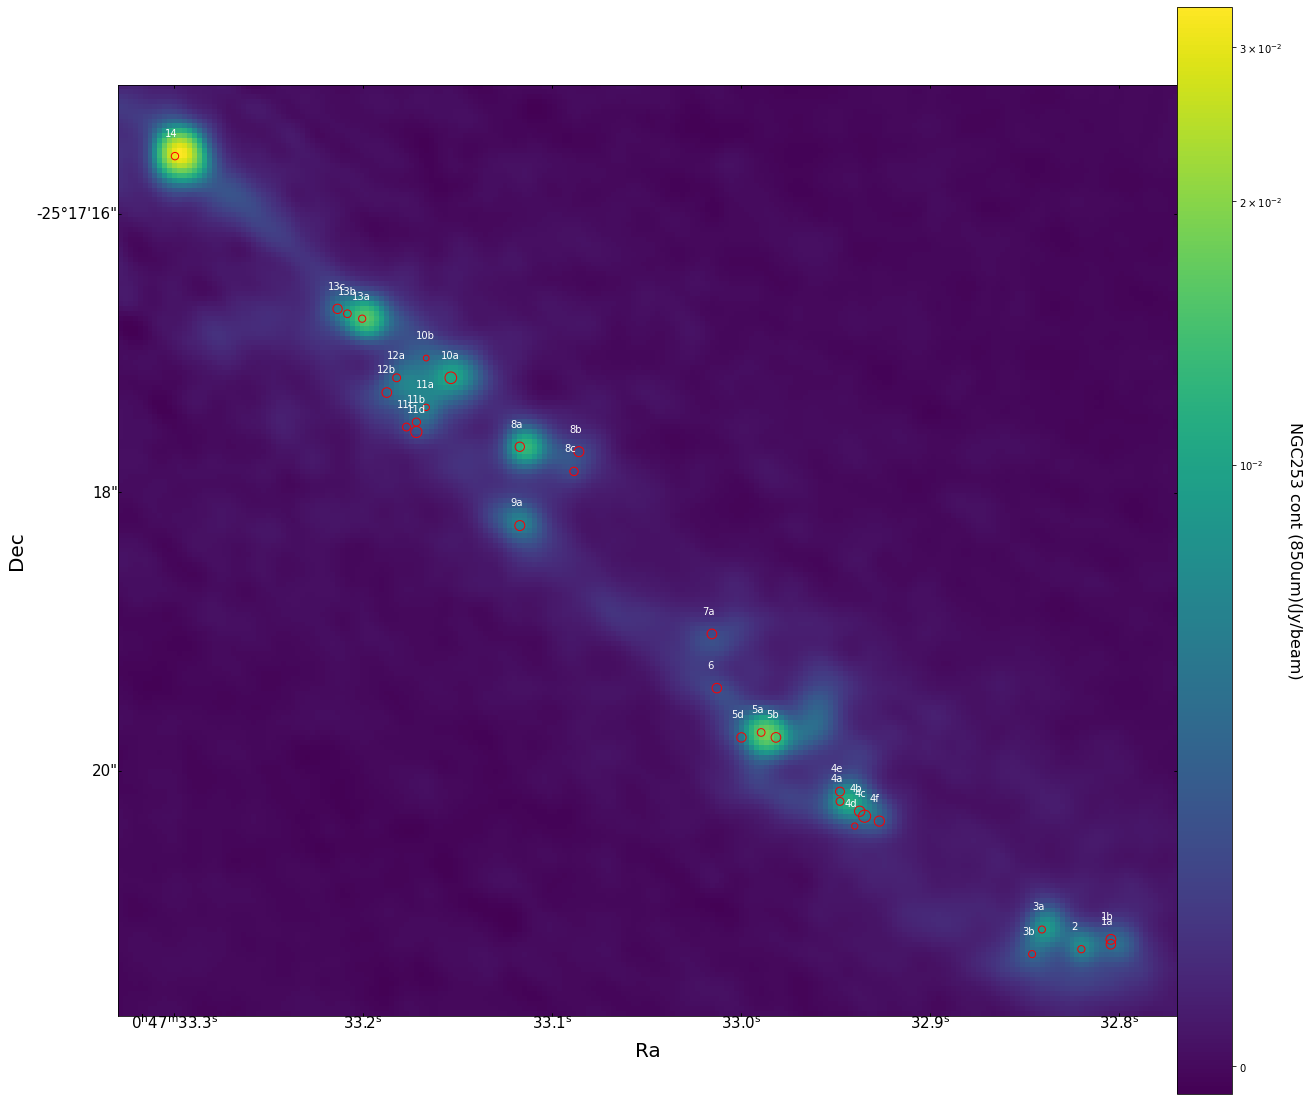

In [35]:
#NGC
IDs,RAs,Decs,HWHM  =    np.genfromtxt("NGC_Clusters_"+"IDs"+"",dtype=type("12h23.14s")),np.genfromtxt("NGC_Clusters_"+"RAs"+"",dtype=type("12h23.14s")),np.genfromtxt("NGC_Clusters_"+"Decs"+"",dtype=type("12h23.14s")),np.genfromtxt("NGC_Clusters_"+"HWHM"+"")
#print(IDs,RAs,Decs,HWHM,type(RAs[0]))

pathCont = 'Continuum_Reproject.fits'
sc= spectral_cube.Projection.from_hdu(fits.open(pathCont)[0])[143:332,220:435]

fig = plt.figure(1,figsize=(20,20))
ax = pylab.subplot(1,1,1,projection=sc.wcs)



RA = ax.coords[0]                                                                  # 
Dec = ax.coords[1]
im = pylab.imshow(sc.hdu.data,norm=colors.SymLogNorm(.01))
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('Ra',fontsize=20,labelpad=1)                               
pylab.ylabel('Dec',fontsize=20,labelpad=1)
ax.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im,fraction=.051,pad=0.0)                                     
cb.set_label(label='NGC253 cont (850um)(Jy/beam)',fontsize=16,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 10)   

for i in range(len(RAs)):
    #print(str(RAs[i]),str(Decs[i]))
    sky = SkyCoord(str(RAs[i]),str(Decs[i]), frame='icrs')
    distance =3.5*u.Mpc
    
    pixel_res = abs(distance.to(u.pc)/u.pc*sc.hdu.header['cdelt1']*np.pi/180)
    
    
    p1,p2 = int(sc.wcs.world_to_pixel(sky)[0]),int(sc.wcs.world_to_pixel(sky)[1]) #Ra,dec
    circle = plt.Circle((p1, p2), HWHM[i]/pixel_res, color='r',fill=False)
    ax.add_patch(circle)
    
    pylab.annotate(s=str(IDs[i]),fontsize=10,xy=(p1-2,p2+4),c="white")  
    #print(p1,p2,np.shape(sc))
pylab.show()

fig.savefig(bbox_inches='tight',fname="NGC253 850um clusters_Zoom.jpeg")

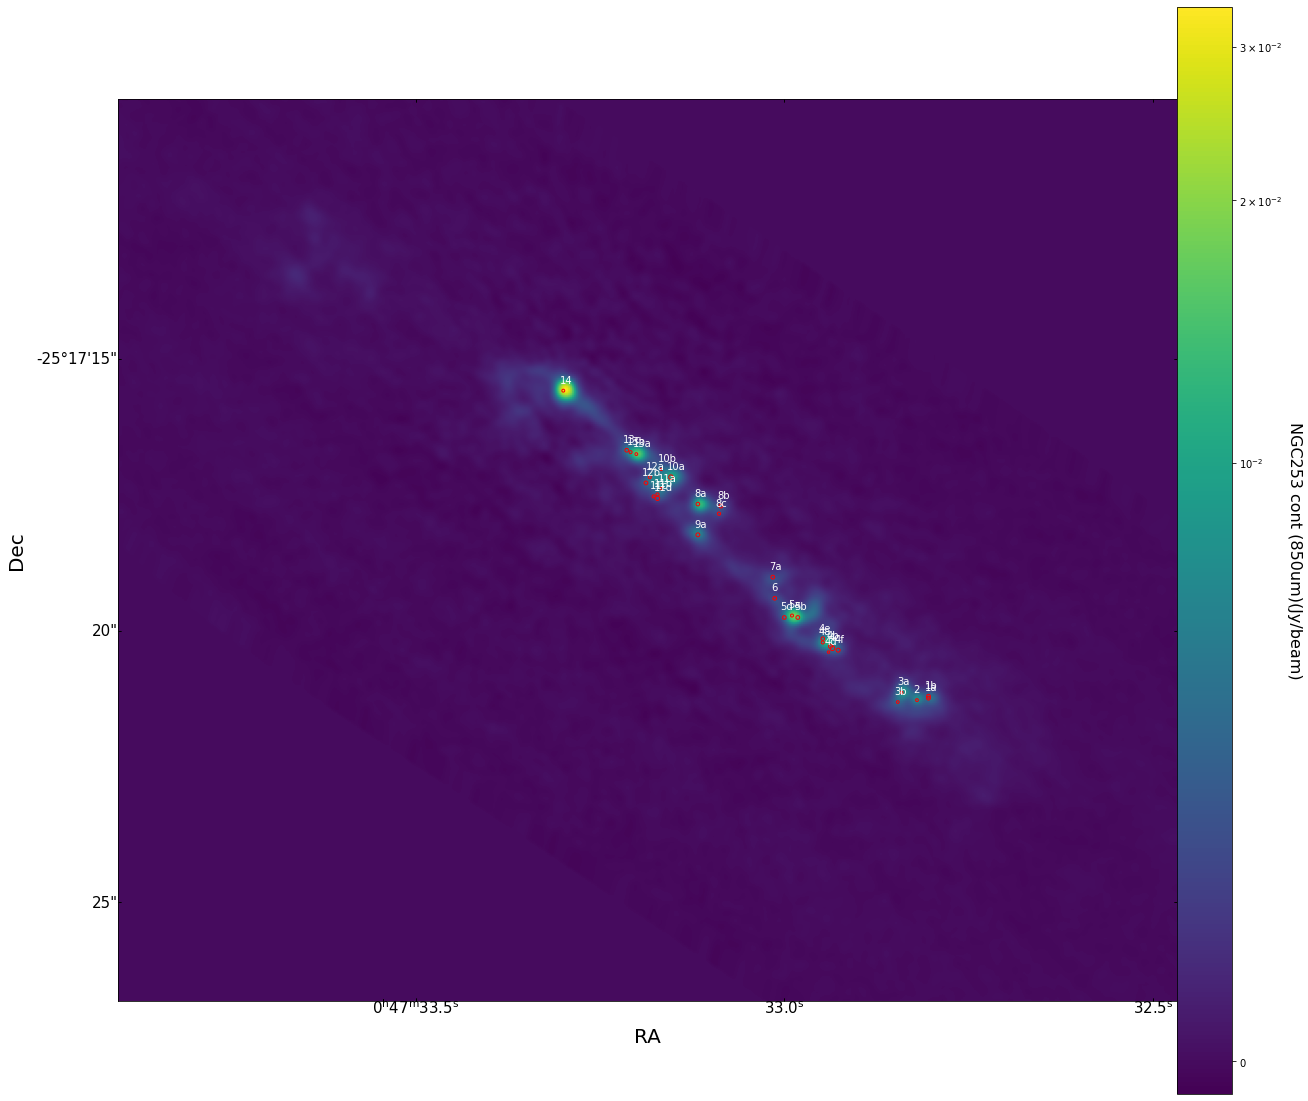

In [36]:
#NGC large
IDs,RAs,Decs,HWHM  =    np.genfromtxt("NGC_Clusters_"+"IDs"+"",dtype=type("12h23.14s")),np.genfromtxt("NGC_Clusters_"+"RAs"+"",dtype=type("12h23.14s")),np.genfromtxt("NGC_Clusters_"+"Decs"+"",dtype=type("12h23.14s")),np.genfromtxt("NGC_Clusters_"+"HWHM"+"")
#print(IDs,RAs,Decs,HWHM,type(RAs[0]))

pathCont = 'Continuum_Reproject.fits'
sc= spectral_cube.Projection.from_hdu(fits.open(pathCont)[0])

fig = plt.figure(1,figsize=(20,20))
ax = pylab.subplot(1,1,1,projection=sc.wcs)



RA = ax.coords[0]                                                                  # 
Dec = ax.coords[1]
im = pylab.imshow(sc.hdu.data,norm=colors.SymLogNorm(.01))
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('RA',fontsize=20,labelpad=1)                               
pylab.ylabel('Dec',fontsize=20,labelpad=1)
ax.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im,fraction=.051,pad=0.0)                                     
cb.set_label(label='NGC253 cont (850um)(Jy/beam)',fontsize=16,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 10)   

for i in range(len(RAs)):
    #print(str(RAs[i]),str(Decs[i]))
    sky = SkyCoord(str(RAs[i]),str(Decs[i]), frame='icrs')
    distance =3.5*u.Mpc
    
    pixel_res = abs(distance.to(u.pc)/u.pc*sc.hdu.header['cdelt1']*np.pi/180)
    
    
    p1,p2 = int(sc.wcs.world_to_pixel(sky)[0]),int(sc.wcs.world_to_pixel(sky)[1]) #Ra,dec
    circle = plt.Circle((p1, p2), HWHM[i]/pixel_res, color='r',fill=False)
    ax.add_patch(circle)
    
    pylab.annotate(s=str(IDs[i]),fontsize=10,xy=(p1-2,p2+4),c="white")  
    #print(p1,p2,np.shape(sc))
pylab.show()

fig.savefig(bbox_inches='tight',fname="NGC253 850um clusters_Large.jpeg")

240 34 (280, 300)
254 43 (280, 300)
196 57 (280, 300)
206 54 (280, 300)
228 66 (280, 300)
248 68 (280, 300)
142 68 (280, 300)
116 92 (280, 300)
102 100 (280, 300)
39 110 (280, 300)
135 108 (280, 300)
156 115 (280, 300)
184 109 (280, 300)
181 117 (280, 300)
163 127 (280, 300)
177 127 (280, 300)
53 132 (280, 300)
151 136 (280, 300)
252 141 (280, 300)
33 143 (280, 300)
125 145 (280, 300)
60 149 (280, 300)
142 154 (280, 300)
176 155 (280, 300)
163 154 (280, 300)
88 161 (280, 300)
171 165 (280, 300)
58 167 (280, 300)
130 175 (280, 300)
190 177 (280, 300)
56 180 (280, 300)
124 234 (280, 300)


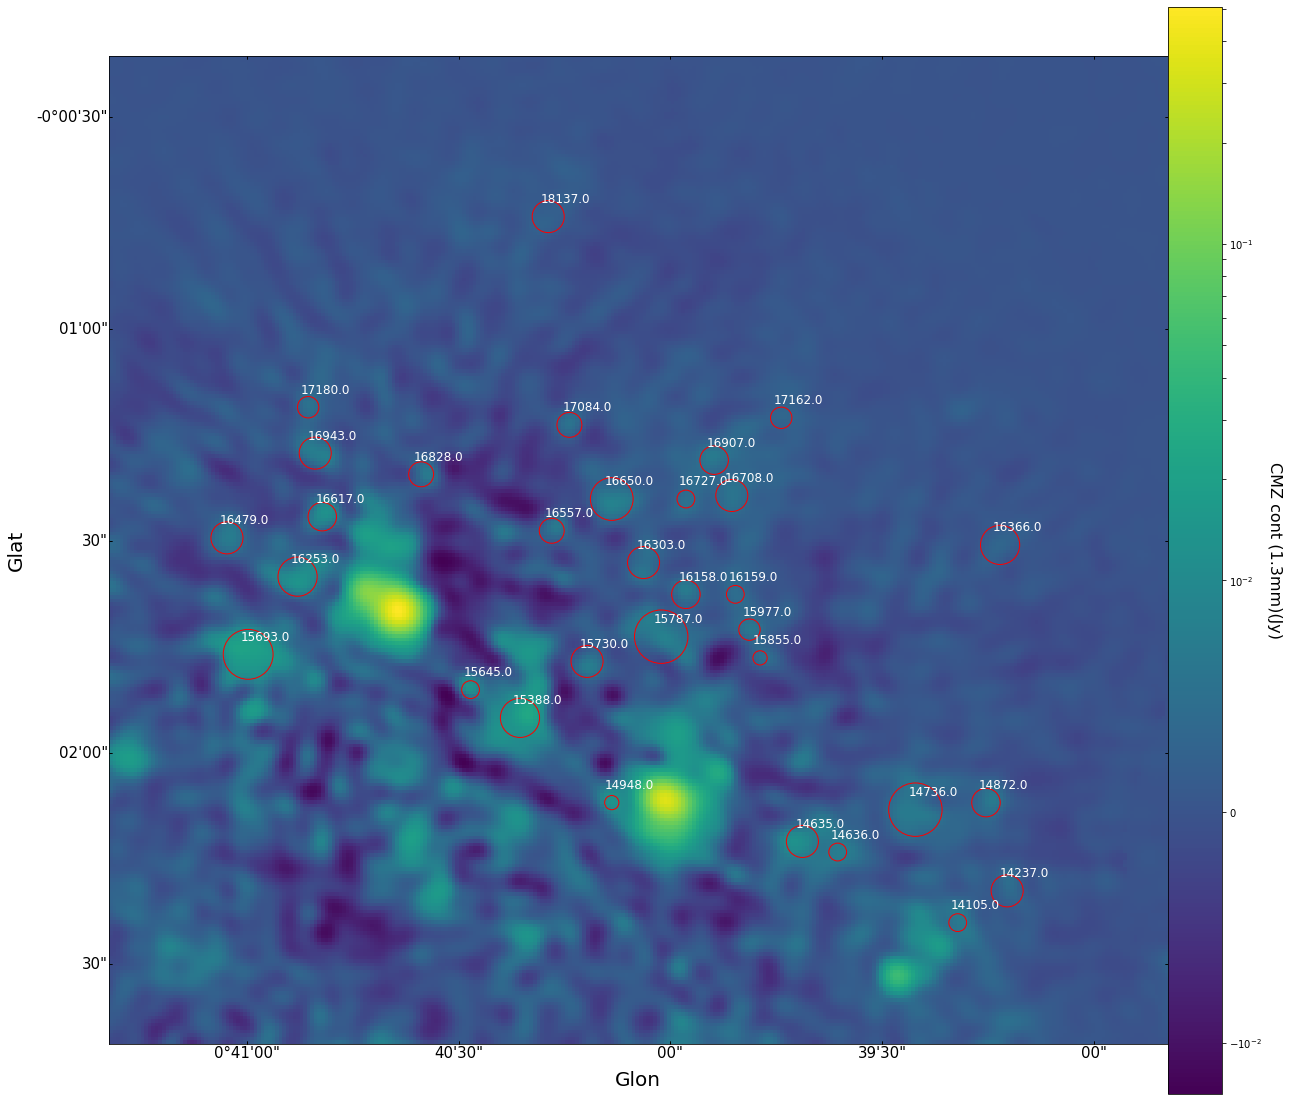

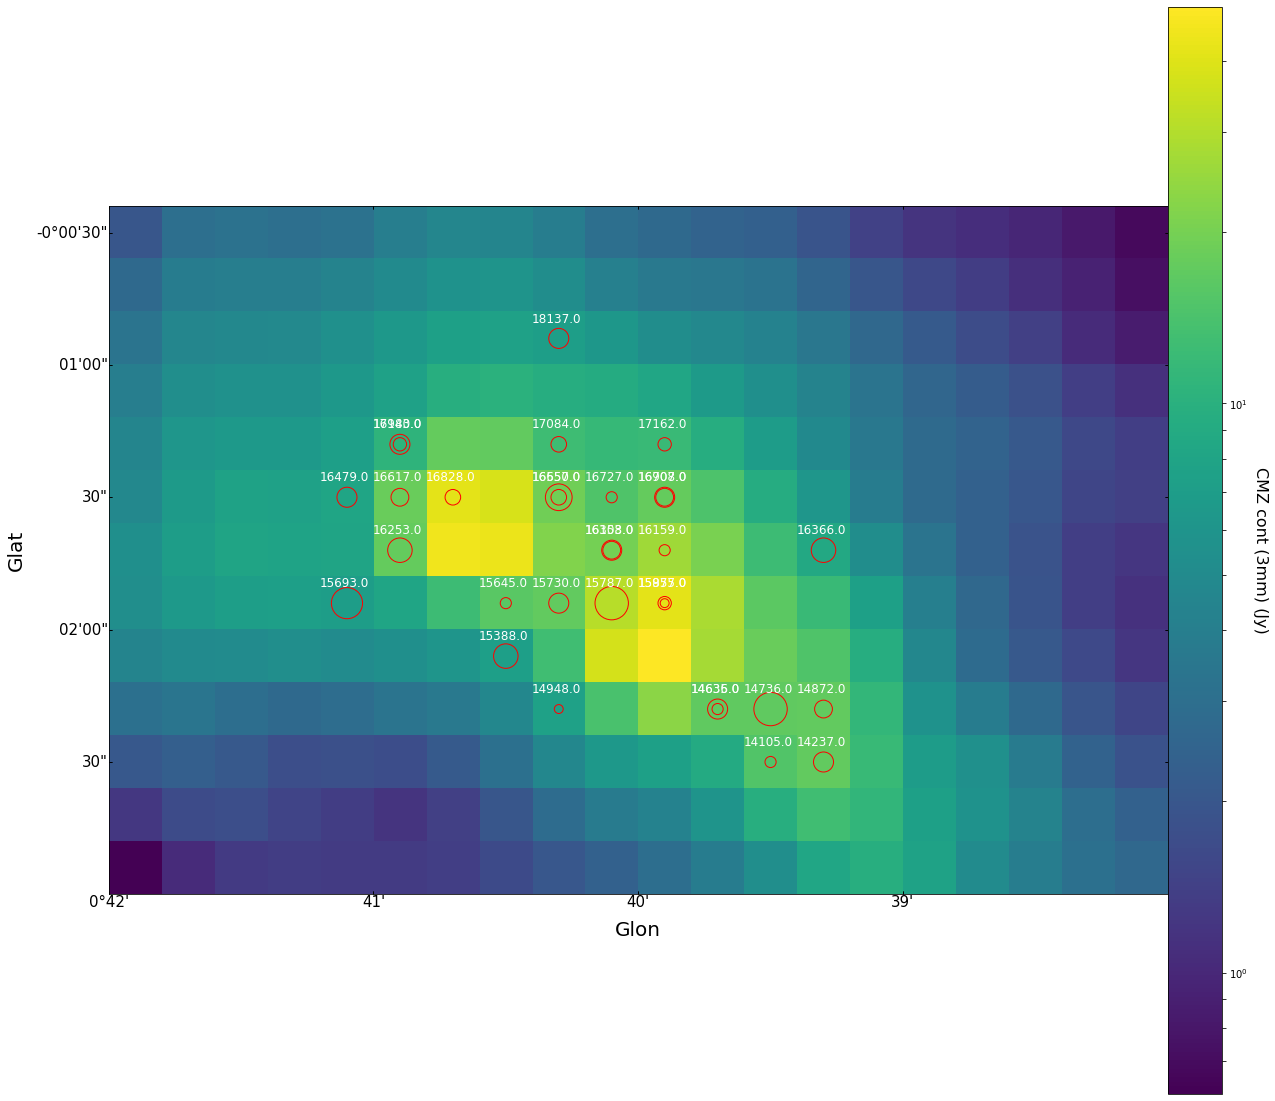

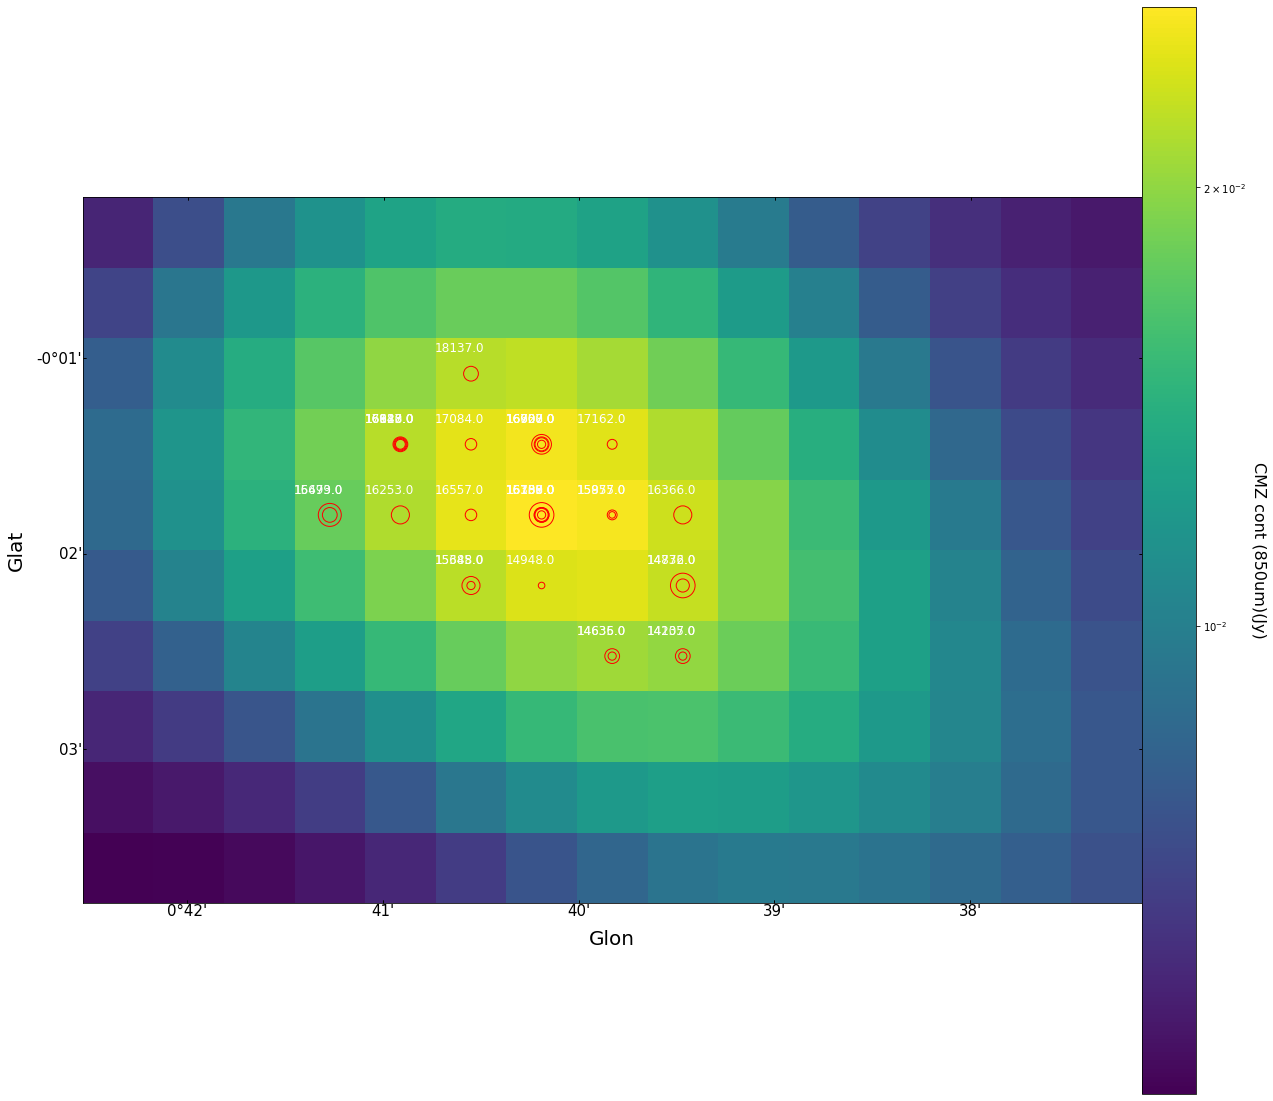

In [24]:
#CMZ
HWHM_rad,CDs_New,glons_New,glats_New,IDs_New   =    np.genfromtxt("CMZ_Clusters_"+"HWHM"+""),np.genfromtxt("CMZ_Clusters_"+"CD"+""),np.genfromtxt("CMZ_Clusters_"+"Glon"+""),np.genfromtxt("CMZ_Clusters_"+"Glat"+""),np.genfromtxt("CMZ_Clusters_"+"IDs"+"")


pathCont = "CMZoom_Jy.fits"
sc= spectral_cube.Projection.from_hdu(fits.open(pathCont)[0])[1660:1940,7550:7850]

fig = plt.figure(1,figsize=(20,20))
ax = pylab.subplot(1,1,1,projection=sc.wcs)



RA = ax.coords[0]                                                                  # 
Dec = ax.coords[1]
im = pylab.imshow(sc.hdu.data,norm=colors.SymLogNorm(.01))
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('Glon',fontsize=20,labelpad=1)                               
pylab.ylabel('Glat',fontsize=20,labelpad=1)
ax.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im,fraction=.051,pad=0.0)                                     
cb.set_label(label='CMZ cont (1.3mm)(Jy)',fontsize=16,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 10)   

for i in range(len(HWHM_rad)):
    sky = SkyCoord(l=float(glons_New[i])*u.deg, b=float(glats_New[i])*u.deg, frame='galactic')
    distance = 8.178*10**-3*u.Mpc
    
    pixel_res = abs(distance.to(u.pc)/u.pc*sc.hdu.header['cdelt1']*np.pi/180)
    
    
    p1,p2 = int(sc.wcs.world_to_pixel(sky)[0]),int(sc.wcs.world_to_pixel(sky)[1]) #Ra,dec
    circle = plt.Circle((p1, p2), HWHM_rad[i]/pixel_res, color='r',fill=False)
    ax.add_patch(circle)
    
    pylab.annotate(s=str(IDs_New[i]),fontsize=12,xy=(p1-2,p2+4),c="white")  
    print(p1,p2,np.shape(sc))
pylab.show()

fig.savefig(bbox_inches='tight',fname="CMZ 1.3mm clusters_Zoom.jpeg")


pathCont = "CMZ_Continuum_Splice.fits"
sc= spectral_cube.Projection.from_hdu(fits.open(pathCont)[0])[80:93,335:355]
sc.allow_huge_operations=True


                   
arc_per_pix_yc =  abs(sc.hdu.header["CDELT1"]*3600.0 * u.arcsec)/u.pix
arc_per_pix_xc =  abs(sc.hdu.header["CDELT2"]*3600.0 * u.arcsec)/u.pix
beam_majorc =  sc.hdu.header["BMAJ"]*3600.0 * u.arcsec
beam_minorc =  sc.hdu.header["BMIN"]*3600.0 * u.arcsec
beam_area_ratioc = beam_minorc*beam_majorc/arc_per_pix_yc/arc_per_pix_xc*1.13309#beam_area_ratioc = beam_minorc*beam_majorc/arc_per_pix_yc/arc_per_pix_xc#This is for FWHM, use *(2*np.sqrt(2*np.log(2)))**2#For gaussian beam
                       
sc= sc/beam_area_ratioc*u.beam #Now in Jy from jy/beam
                       
                       
fig = plt.figure(1,figsize=(20,20))
ax = pylab.subplot(1,1,1,projection=sc.wcs)



RA = ax.coords[0]                                                                  # 
Dec = ax.coords[1]
im = pylab.imshow(sc.hdu.data,norm=colors.SymLogNorm(.01))
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('Glon',fontsize=20,labelpad=1)                               
pylab.ylabel('Glat',fontsize=20,labelpad=1)
ax.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im,fraction=.0511,pad=0.0)                                     
cb.set_label(label='CMZ cont (3mm) (Jy)',fontsize=16,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 10)   


for i in range(len(HWHM_rad)):
    sky = SkyCoord(l=float(glons_New[i])*u.deg, b=float(glats_New[i])*u.deg, frame='galactic')
    distance = 8.178*10**-3*u.Mpc
    
    pixel_res = abs(distance.to(u.pc)/u.pc*sc.hdu.header['cdelt1']*np.pi/180)
    

    p1,p2 = int(sc.wcs.world_to_pixel(sky)[0]),int(sc.wcs.world_to_pixel(sky)[1]) #Ra,dec
    circle = plt.Circle((p1, p2), HWHM_rad[i]/pixel_res, color='r',fill=False)
    ax.add_patch(circle)
    
    pylab.annotate(s=str(IDs_New[i]),fontsize=12,xy=(p1-.51,p2+.31),c="white")  
    
    
pylab.show()

fig.savefig(bbox_inches='tight',fname="CMZ 3mm clusters_Zoom.jpeg")

pathCont ='4.3pc_beam_CMZ_850um_Cont_140x800pc.fits'

sc= spectral_cube.Projection.from_hdu(fits.open(pathCont)[0])[155:165,380:395]
sc.allow_huge_operations=True


                   
arc_per_pix_yc =  abs(sc.hdu.header["CDELT1"]*3600.0 * u.arcsec)/u.pix
arc_per_pix_xc =  abs(sc.hdu.header["CDELT2"]*3600.0 * u.arcsec)/u.pix
beam_majorc =  sc.hdu.header["BMAJ"]*3600.0 * u.arcsec
beam_minorc =  sc.hdu.header["BMIN"]*3600.0 * u.arcsec
beam_area_ratioc = beam_minorc*beam_majorc/arc_per_pix_yc/arc_per_pix_xc*1.13309#beam_area_ratioc = beam_minorc*beam_majorc/arc_per_pix_yc/arc_per_pix_xc#This is for FWHM, use *(2*np.sqrt(2*np.log(2)))**2#For gaussian beam
                       
sc= sc/beam_area_ratioc*u.beam #Now in Jy from jy/beam
                       
                       
fig = plt.figure(1,figsize=(20,20))
ax = pylab.subplot(1,1,1,projection=sc.wcs)



RA = ax.coords[0]                                                                  # 
Dec = ax.coords[1]
im = pylab.imshow(sc.hdu.data,norm=colors.SymLogNorm(.01))
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('Glon',fontsize=20,labelpad=1)                               
pylab.ylabel('Glat',fontsize=20,labelpad=1)
ax.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im,fraction=.0511,pad=0.0)                                     
cb.set_label(label='CMZ cont (850um)(Jy)',fontsize=16,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 10)   


for i in range(len(HWHM_rad)):
    sky = SkyCoord(l=float(glons_New[i])*u.deg, b=float(glats_New[i])*u.deg, frame='galactic')
    distance = 8.178*10**-3*u.Mpc
    
    pixel_res = abs(distance.to(u.pc)/u.pc*sc.hdu.header['cdelt1']*np.pi/180)
    

    p1,p2 = int(sc.wcs.world_to_pixel(sky)[0]),int(sc.wcs.world_to_pixel(sky)[1]) #Ra,dec
    circle = plt.Circle((p1, p2), HWHM_rad[i]/pixel_res, color='r',fill=False)
    ax.add_patch(circle)
    
    pylab.annotate(s=str(IDs_New[i]),fontsize=12,xy=(p1-.51,p2+.31),c="white")  
    
    
pylab.show()


fig.savefig(bbox_inches='tight',fname="CMZ 850um clusters_Zoom.jpeg")

7790 1694 (2800, 19000)
7804 1703 (2800, 19000)
7746 1717 (2800, 19000)
7756 1714 (2800, 19000)
7778 1726 (2800, 19000)
7798 1728 (2800, 19000)
7692 1728 (2800, 19000)
7666 1752 (2800, 19000)
7652 1760 (2800, 19000)
7589 1770 (2800, 19000)
7685 1768 (2800, 19000)
7706 1775 (2800, 19000)
7734 1769 (2800, 19000)
7731 1777 (2800, 19000)
7713 1787 (2800, 19000)
7727 1787 (2800, 19000)
7603 1792 (2800, 19000)
7701 1796 (2800, 19000)
7802 1801 (2800, 19000)
7583 1803 (2800, 19000)
7675 1805 (2800, 19000)
7610 1809 (2800, 19000)
7692 1814 (2800, 19000)
7726 1815 (2800, 19000)
7713 1814 (2800, 19000)
7638 1821 (2800, 19000)
7721 1825 (2800, 19000)
7608 1827 (2800, 19000)
7680 1835 (2800, 19000)
7740 1837 (2800, 19000)
7606 1840 (2800, 19000)
7674 1894 (2800, 19000)


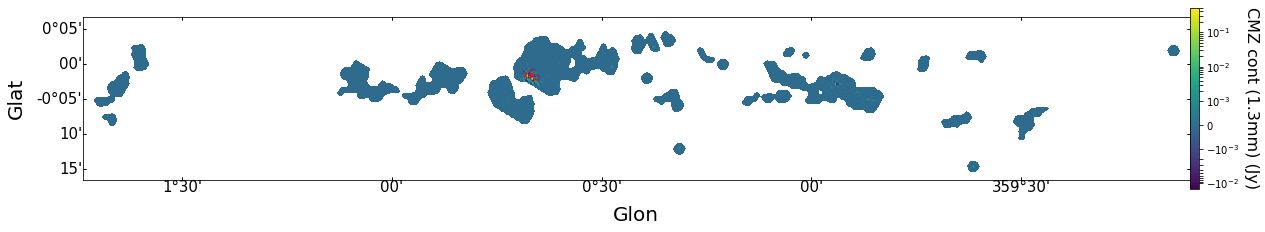

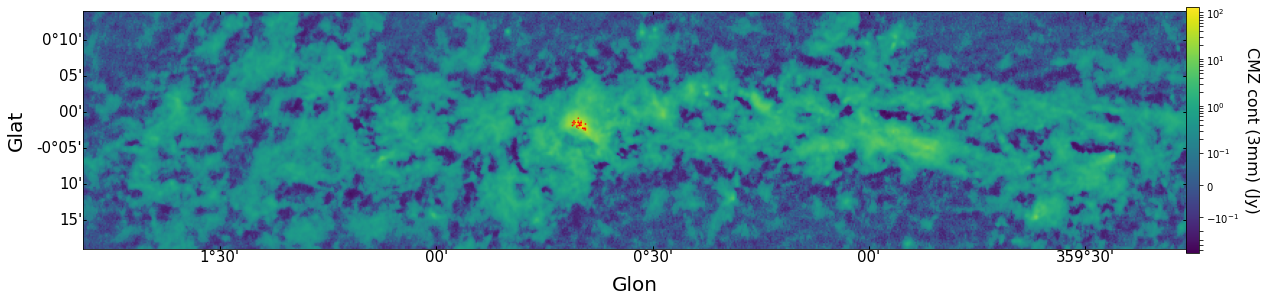

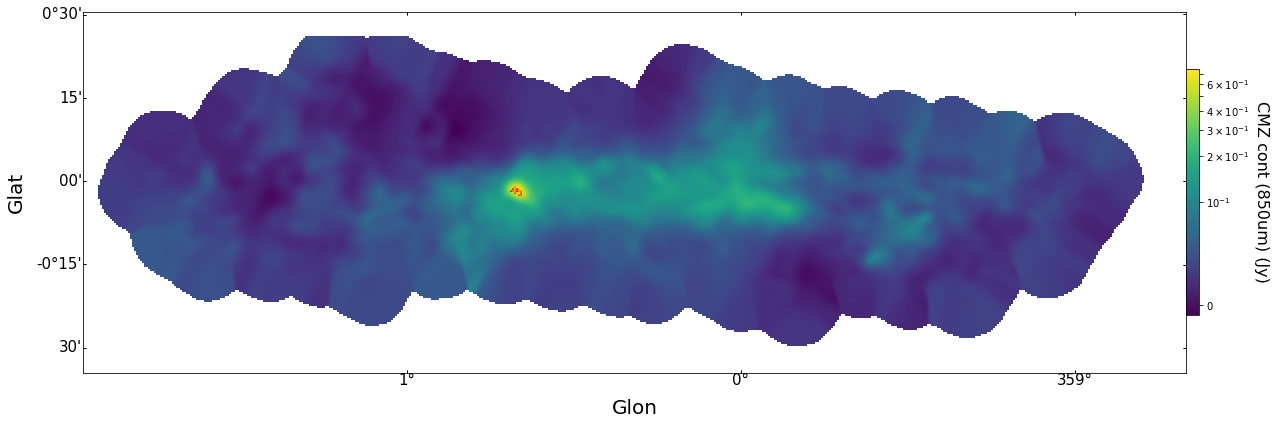

In [25]:
### CMZ LArge
HWHM_rad,CDs_New,glons_New,glats_New,IDs_New   =    np.genfromtxt("CMZ_Clusters_"+"HWHM"+""),np.genfromtxt("CMZ_Clusters_"+"CD"+""),np.genfromtxt("CMZ_Clusters_"+"Glon"+""),np.genfromtxt("CMZ_Clusters_"+"Glat"+""),np.genfromtxt("CMZ_Clusters_"+"IDs"+"")


pathCont = "CMZoom_Jy.fits"
sc= spectral_cube.Projection.from_hdu(fits.open(pathCont)[0])

fig = plt.figure(1,figsize=(20,20))
ax = pylab.subplot(1,1,1,projection=sc.wcs)



RA = ax.coords[0]                                                                  # 
Dec = ax.coords[1]
im = pylab.imshow(sc.hdu.data,norm=colors.SymLogNorm(.001))
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('Glon',fontsize=20,labelpad=1)                               
pylab.ylabel('Glat',fontsize=20,labelpad=1)
ax.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im,fraction=.0081,pad=0.0)                                     
cb.set_label(label='CMZ cont (1.3mm) (Jy)',fontsize=16,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 10)   

for i in range(len(HWHM_rad)):
    sky = SkyCoord(l=float(glons_New[i])*u.deg, b=float(glats_New[i])*u.deg, frame='galactic')
    distance = 8.178*10**-3*u.Mpc
    
    pixel_res = abs(distance.to(u.pc)/u.pc*sc.hdu.header['cdelt1']*np.pi/180)
    
    
    p1,p2 = int(sc.wcs.world_to_pixel(sky)[0]),int(sc.wcs.world_to_pixel(sky)[1]) #Ra,dec
    circle = plt.Circle((p1, p2), HWHM_rad[i]/pixel_res, color='r',fill=False)
    ax.add_patch(circle)
    
    #pylab.annotate(s=str(IDs_New[i]),fontsize=20,xy=(p1-2,p2+4),c="white")  
    print(p1,p2,np.shape(sc))
pylab.show()

fig.savefig(bbox_inches='tight',fname="CMZ 1.3mm clusters_Large.jpeg")

pathCont = "CMZ_Continuum_Splice.fits"


sc= spectral_cube.Projection.from_hdu(fits.open(pathCont)[0])

fig = plt.figure(1,figsize=(20,20))
ax = pylab.subplot(1,1,1,projection=sc.wcs)



RA = ax.coords[0]                                                                  # 
Dec = ax.coords[1]
im = pylab.imshow(sc.hdu.data,norm=colors.SymLogNorm(.1))
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('Glon',fontsize=20,labelpad=1)                               
pylab.ylabel('Glat',fontsize=20,labelpad=1)
ax.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im,fraction=.011,pad=0.0)                                     
cb.set_label(label='CMZ cont (3mm) (Jy)',fontsize=16,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 10)   


for i in range(len(HWHM_rad)):
    sky = SkyCoord(l=float(glons_New[i])*u.deg, b=float(glats_New[i])*u.deg, frame='galactic')
    distance = 8.178*10**-3*u.Mpc
    
    pixel_res = abs(distance.to(u.pc)/u.pc*sc.hdu.header['cdelt1']*np.pi/180)
    

    p1,p2 = int(sc.wcs.world_to_pixel(sky)[0]),int(sc.wcs.world_to_pixel(sky)[1]) #Ra,dec
    circle = plt.Circle((p1, p2), HWHM_rad[i]/pixel_res, color='r',fill=False)
    ax.add_patch(circle)
    
    #pylab.annotate(s=str(IDs_New[i]),fontsize=20,xy=(p1-1,p2+.51),c="white")  
    
    
pylab.show()


fig.savefig(bbox_inches='tight',fname="CMZ 3mm clusters_Large.jpeg")


#pathCont= 'gc_850micron_dust.fits'
pathCont ='4.3pc_beam_CMZ_850um_Cont_140x800pc.fits'

sc= spectral_cube.Projection.from_hdu(fits.open(pathCont)[0])[70:250,170:720]

fig = plt.figure(1,figsize=(20,20))
ax = pylab.subplot(1,1,1,projection=sc.wcs)


RA = ax.coords[0]                                                                  # 
Dec = ax.coords[1]
im = pylab.imshow(sc.hdu.data,norm=colors.SymLogNorm(.1))
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('Glon',fontsize=20,labelpad=1)                               
pylab.ylabel('Glat',fontsize=20,labelpad=1)
ax.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im,fraction=.011,pad=0.0)                                     
cb.set_label(label='CMZ cont (850um) (Jy)',fontsize=16,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 10)   


for i in range(len(HWHM_rad)):
    sky = SkyCoord(l=float(glons_New[i])*u.deg, b=float(glats_New[i])*u.deg, frame='galactic')
    distance = 8.178*10**-3*u.Mpc
    
    pixel_res = abs(distance.to(u.pc)/u.pc*sc.hdu.header['cdelt1']*np.pi/180)
    

    p1,p2 = int(sc.wcs.world_to_pixel(sky)[0]),int(sc.wcs.world_to_pixel(sky)[1]) #Ra,dec
    circle = plt.Circle((p1, p2), HWHM_rad[i]/pixel_res, color='r',fill=False)
    ax.add_patch(circle)
    
    #pylab.annotate(s=str(IDs_New[i]),fontsize=20,xy=(p1-1,p2+.51),c="white")  
    
    
pylab.show()
fig.savefig(bbox_inches='tight',fname="CMZ 850um clusters_Large.jpeg")

In [54]:
#convert to text file
#Cat=Table.read('catalog_complete.fits')

#print(Cat)
#Cat.write('Catalog_Perry.txt', format='ascii', overwrite=True) 

index    area_ellipse    ...      tff_unc         mass_bgsub_unc  
           arcsec2       ...         s               solMass      
----- ------------------ ... ------------------ ------------------
   99  15.93642962736847 ... 40364.878444677124 28.004956882514854
  106  4.481017865461146 ...  36336.01172621685 7.7625696716640125
  107  15.16677292435799 ...  88240.30238690706 20.302784331489338
  118  50.27924382752407 ...  21493.02880747616  412.6814557764171
  120  1.558979889852178 ... 23474.057586838502  1.915012833556888
  122 11.752823560482662 ...  26695.68309899199  16.83295172280969
  ...                ... ...                ...                ...
24431 1.8082178108319533 ...  32774.01239651737 1.4674924698346739
24463 3.3068893931643846 ...  35331.21281243157 3.0039289032933283
24493 2.3051053763686116 ...  46331.70768668499  5.539534956423093
24640  6.210266180328843 ... 59760.500365758715  15.37762525442371
24664  5.854262370195552 ...   69743.6925050793 7.522718286963